# Analyzing Personal and Textual Networks

[David J. Thomas](mailto:dave.a.base@gmail.com), [thePortus.com](http://thePortus.com)<br />
Instructor of Ancient History and Digital Humanities,<br />
Department of History,<br />
[University of South Florida](https://github.com/usf-portal)

---

## This workbook will...

* Use the `networkx` module to make different network graphs...
    * People co-appearing as witnesses in the same charters
    * Charters who share the same witness(es)
* Draw a quick preview of the networks
* Calculate several network statistics

---

## 1) Import Module Dependencies

The cell below loads all other Python packages needed. You **must** run this before any other cells.

In [1]:
import sqlalchemy as sql
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import networkx as nx
import matplotlib.pyplot as plt

## 2) (Re)declare Database Models

In [2]:
engine = sql.create_engine('sqlite:///charters.db', echo=False)
Base = declarative_base()
    

class Charter(Base):
    __tablename__ = 'charters'

    id = sql.Column(sql.String, primary_key=True)
    description = sql.Column(sql.String)
    sawyer = sql.Column(sql.Integer)
    birch = sql.Column(sql.Integer)
    kemble = sql.Column(sql.Integer)
    british_academy = sql.Column(sql.String)
    source_used = sql.Column(sql.String)
    archive = sql.Column(sql.String)
    language = sql.Column(sql.String)
    date = sql.Column(sql.Integer)
    scholarly_date = sql.Column(sql.String)
    scholarly_date_low = sql.Column(sql.Integer)
    scholarly_date_high = sql.Column(sql.Integer)
    scholarly_date_avg = sql.Column(sql.Float)
    text = sql.Column(sql.Text)
    notes = sql.Column(sql.Text)
    asc_source = sql.Column(sql.String)
    pase_source = sql.Column(sql.String)
    pase_witnesses = sql.Column(sql.String)
    
    witnesses = sql.orm.relationship('Person', secondary='charter_witnesses', back_populates='charters')
    
    @property
    def record(self):
        """Gets entry data in dictionary format."""
        return {
            'id': self.id,
            'label': self.id,
            'sawyer': self.sawyer,
            'birch': self.birch,
            'kemble': self.kemble,
            'british_academy': self.british_academy,
            'source_used': self.source_used,
            'archive': self.archive,
            'language': self.language,
            'date': self.date,
            'scholarly_date': self.scholarly_date,
            'scholarly_date_low': self.scholarly_date_low,
            'scholarly_date_high': self.scholarly_date_high,
            'scholarly_date_avg': self.scholarly_date_avg,
            'text': self.text,
            'notes': self.notes,
            'asc_source': self.asc_source,
            'pase_source': self.pase_source,
            'pase_witnesses': self.pase_witnesses
        }
    
    def num_common_witnesses(self, other_charter):
        """Checks self and other_charter for the number of witnesses that appear in both charters."""
        total_counter = 0
        for witness in self.witnesses:
            for other_witness in other_person.witnesses:
                if witness.id == other_witness.id:
                    total_counter += 1
        return total_counter
                    
    
class Person(Base):
    __tablename__ = 'people'
    
    id = sql.Column(sql.String, primary_key=True)
    description = sql.Column(sql.String)
    link = sql.Column(sql.String)
    
    charters = sql.orm.relationship('Charter', secondary='charter_witnesses', back_populates='witnesses')
    
    @property
    def record(self):
        """Gets entry data in dictionary format."""
        return {
            'id': self.id,
            'label': self.id + ': ' + self.description,
            'link': self.link
        }
    
    @property
    def earliest_appearance(self):
        """Returns the date of the earliest charter features said person."""
        earliest_charter = None
        for charter in self.charters:
            if not earliest_charter:
                earliest_charter = charter.scholarly_date_avg
            else:
                if charter.scholarly_date_avg < earliest_charter:
                    earliest_charter = charter.scholarly_date_avg
        return earliest_charter
    
    def num_coappearances(self, other_person):
        """Checks the number of times this person appears in the same charters as other_person"""
        total_counter = 0
        for charter in self.charters:
            for other_charter in other_person.charters:
                if charter.id == other_charter.id:
                    total_counter += 1
        return total_counter

    
class CharterWitness(Base):
    __tablename__ = 'charter_witnesses'
    charter_id = sql.Column(sql.String, sql.ForeignKey('charters.id'), primary_key=True) 
    person_id = sql.Column(sql.String, sql.ForeignKey('people.id'), primary_key=True)
    role = sql.Column(sql.String)
    link = sql.Column(sql.String)
    
    @property
    def record(self):
        """Gets entry data in dictionary format."""
        return {
            'charter_id': self.charter_id,
            'person_id': self.person_id,
            'label': self.role,
            'link': self.link
        }


print('Database Configured Successfully')

Database Configured Successfully


# 3) Build Co-Appearing Witness Graph

In [6]:
# first we need to open a session with the local database, get every witness, then close the connection
session = sessionmaker(bind=engine)()
witnesses = session.query(Person)
session.close()

print('Building network graph...', end='')
# create an empty networkx graph
witness_network = nx.Graph(
    label='',
    link=None,
    weight=1,
    type='Undirected',
    label_propagation_community=None,
    asyn_lpa_community=None,
    greedy_color=None,
    degree=0,
    triangles=0,
    clustering=0,
    avg_clustering=0,
    square_clustering=0,
    degree_centrality=0,
    betweeness_centrality=0,
    eigenvector_centrality=0,
    closeness_centrality=0,
    harmonic_centrality=0,
)

# populate the nodes with each witness record
for person in witnesses:
    witness_network.add_node(person.id, **person.record)

counter = 0
# to build edges, we need to compare every witness against each other for the number of times they appear
for index, person in enumerate(witnesses):
    for other_person in witnesses[index + 1:]:
        counter += 1
        if counter % 20000 == 0:
            print('.', end='')
        num_coappearances = person.num_coappearances(other_person)
        # only add an edge if they actually appeared together
        if num_coappearances > 0:
            witness_network.add_edge(
                person.id,
                other_person.id,
                label='{} -> {}'.format(person.id, other_person.id),
                weight=person.num_coappearances(other_person),
                type='Undirected'
            )

print('\n\nFinished.')

Building network graph.................................................................................................

Finished.


# 4) Analyzing Witness Network Graph

### 4a) Define Function to Merge Results and Make a Placeholder

In [7]:
def merge_network_stats(network, result_set, attribute_name):
    """Copys results of a network calculation into a network under desired attribute name."""
    # loop through keywords in result set
    for node_id in network.nodes():
        new_node_stat = result_set[node_id]
        network.nodes[node_id][attribute_name] = new_node_stat
    return network

results = {
    'greedy_color': {},
    'degree': {},
    'triangles': {},
    'clustering': {},
    'square_clustering': {},
    'label_propagation_community': {},
    'k_clique_communities': {},
    'degree_centrality': {},
    'betweeness_centrality': {},
    'eigenvectory_centrality': {},
    'closeness_centrality': {},
    'harmonic_centrality': {}
}

print('Finished declaring function and placeholder.')

Finished declaring function and placeholder.


### 4b) Basic Stats

In [8]:
print('Greedy coloring...', end='')
results['color'] = nx.greedy_color(witness_network)

print(' Done!\nDegrees...', end='')
results['degree'] = nx.degree(witness_network)

print(' Done!\n\nFinished calculating basic statistics')

Greedy coloring... Done!
Degrees... Done!

Finished calculating basic statistics


### 4c) Clustering

In [9]:
print('Number of triangles...', end='')
results['triangles'] = nx.triangles(witness_network)
print(' Done!\nClustering Coefficient...', end='')
results['clustering'] = nx.triangles(witness_network)
results['avg_clustering'] = nx.average_clustering(witness_network)
print(' Done!\nSquare Clustering Coefficient...', end='')
results['square_clustering'] = nx.square_clustering(witness_network)
print(' Done!\n\nFinished calculating clustering statistics.')

Number of triangles... Done!
Clustering Coefficient... Done!
Square Clustering Coefficient... Done!

Finished calculating clustering statistics.


### 4d) Communities

In [10]:
def convert_community_stats(result_set):
    converted_results = {}
    counter = 0
    for community in result_set:
        counter += 1
        for node in community:
            converted_results[node] = counter
    return converted_results


print('Community detection with label propagation...', end='')
results['label_propagation_community'] = convert_community_stats(
    nx.algorithms.community.label_propagation.label_propagation_communities(witness_network)
)

print(' Done!\n\nFinished calculating communities.')

Community detection with label propagation... Done!

Finished calculating communities.


### 4e) Centralities

In [11]:
# centralities
print('Degree centrality...', end='')
results['degree_centrality'] = nx.degree_centrality(witness_network)
print(' Done!\nBetweeness (shortest-path) centrality...', end='')
results['betweeness_centrality'] = nx.betweenness_centrality(witness_network)
print(' Done!\nEigenvector centrality...', end='')
results['eigenvector_centrality'] = nx.eigenvector_centrality(witness_network)
print(' Done!\nCloseness centrality...', end='')
results['closeness_centrality'] = nx.closeness_centrality(witness_network)
print(' Done!\nHarmonic centrality...', end='')
results['harmonic_centrality'] =  nx.harmonic_centrality(witness_network)

print(' Done!\n\nFinished calculated centralities.')

Degree centrality... Done!
Betweeness (shortest-path) centrality... Done!
Eigenvector centrality... Done!
Closeness centrality... Done!
Harmonic centrality... Done!

Finished calculated centralities.


### 4f) Merge Stats Back Into Network as Node Attributes

In [13]:
def merge_stats(network, result_set, attribute_list):
    """Add each stat result set into the network under a node attribute."""
    for attribute_name in attribute_list:
        network = merge_network_stats(network, results[attribute_name], attribute_name)
    return network

stat_attribute_list = [
    'color', 'degree', 'triangles', 'clustering', 'square_clustering', 'label_propagation_community',
    'degree_centrality', 'betweeness_centrality', 'eigenvector_centrality', 'closeness_centrality',
    'harmonic_centrality'
]

witness_network = merge_stats(witness_network, results, stat_attribute_list)

print('Finished, network populated with calculated statistics.')

Finished, network populated with calculated statistics.


## 5) Visualize Witness Network

Generating network preview...
Preview generated.


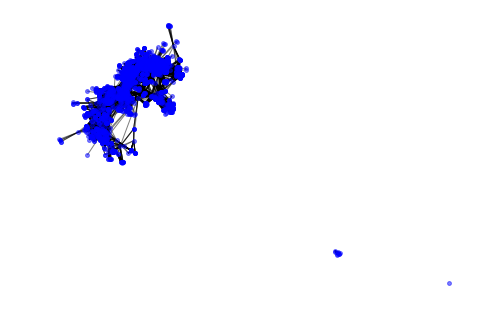

In [19]:
options = {
    'node_color': 'blue',
    'node_size': 15,
    'width': 1,
    'alpha': 0.5
}

print('Generating network preview...')
nx.draw(witness_network, pos=nx.spring_layout(witness_network), **options)
plt.draw()
print('Preview generated.')

## 6) Export Witness Network to File

In [ ]:
print('Exporting witness network as GEXF (.gexf) network graph file')
nx.write_gexf(witness_network, '../export/witness_network.gexf')
print('Network statistics successfully saved in the export folder, open in Gephi or other network tool.')

Exporting witness network as GEXF (.gexf) network graph file
